In [1]:
import scipy as sp
import scipy.io
from scipy import stats
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import csv
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as plt
import matplotlib.patches as patch
from matplotlib import gridspec
from datetime import datetime, timedelta
from tqdm import tqdm

In [2]:
plt.style.use('seaborn-white')
plt.close('all')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 13}
plt.rc('font', **font)
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
size_mult = 1

### Load relevant DonorsChoose data

In [3]:
projects_df = pd.read_csv('Projects.csv')
donations_df = pd.read_csv('Donations.csv')

In [4]:
projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110017 entries, 0 to 1110016
Data columns (total 18 columns):
Project ID                          1110017 non-null object
School ID                           1110017 non-null object
Teacher ID                          1110017 non-null object
Teacher Project Posted Sequence     1110017 non-null int64
Project Type                        1110017 non-null object
Project Title                       1110011 non-null object
Project Essay                       1110016 non-null object
Project Short Description           1110014 non-null object
Project Need Statement              1110014 non-null object
Project Subject Category Tree       1109988 non-null object
Project Subject Subcategory Tree    1109988 non-null object
Project Grade Level Category        1110017 non-null object
Project Resource Category           1109981 non-null object
Project Cost                        1110017 non-null float64
Project Posted Date                 1110017 non

In [5]:
projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110017 entries, 0 to 1110016
Data columns (total 18 columns):
Project ID                          1110017 non-null object
School ID                           1110017 non-null object
Teacher ID                          1110017 non-null object
Teacher Project Posted Sequence     1110017 non-null int64
Project Type                        1110017 non-null object
Project Title                       1110011 non-null object
Project Essay                       1110016 non-null object
Project Short Description           1110014 non-null object
Project Need Statement              1110014 non-null object
Project Subject Category Tree       1109988 non-null object
Project Subject Subcategory Tree    1109988 non-null object
Project Grade Level Category        1110017 non-null object
Project Resource Category           1109981 non-null object
Project Cost                        1110017 non-null float64
Project Posted Date                 1110017 non

In [6]:
display(projects_df.head(3))
display(donations_df.head(2))

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...,Literacy & Language,ESL,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,Fully Funded,2013-05-22


,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23


### Subset data to only include projects that have been fully funded or expired
##### Projects expire 4 months after posting if not fully funded. Fill in these dates for expired projects

In [7]:
finished_projects_df = projects_df[projects_df['Project Current Status'].str.contains('Fully Funded|Expired')].copy()

###convert date columns to datetime
rel_date_cols = ['Project Posted Date', 'Project Fully Funded Date', 'Project Expiration Date']
finished_projects_df[rel_date_cols] = finished_projects_df[rel_date_cols].apply(pd.to_datetime)

#### a few 'Project Expiration Date' are empty - fill in with 'Project posted date' + 4 months
nulls = finished_projects_df['Project Expiration Date'].isnull()
finished_projects_df.loc[nulls, 'Project Expiration Date'] = (finished_projects_df.loc[nulls, 'Project Posted Date'] +
                                                              pd.DateOffset(months = 4))

### fill in 'project end date' for projects that expired with 'Project expiration date'
expired = finished_projects_df['Project Fully Funded Date'].isnull()
finished_projects_df.loc[expired, 'Project Fully Funded Date'] = finished_projects_df.loc[expired, 'Project Expiration Date']
finished_projects_df = finished_projects_df.rename(columns = {'Project Fully Funded Date':'Project End'})

### certain projects did not have a valid expiration date - fill those in with posting date + 4 months
nulls = finished_projects_df['Project End'].isnull()
finished_projects_df.loc[nulls, 'Project End'] = finished_projects_df.loc[nulls, 'Project Posted Date'] + pd.DateOffset(months = 4)
finished_projects_df['Days Open'] = ((finished_projects_df['Project End'] - finished_projects_df['Project Posted Date'])/
                                     np.timedelta64(1, 'D')).astype(int)

## calculate the amount of time each project is allowed to stay active before expiration
finished_projects_df['Alloted Time'] = pd.to_numeric((finished_projects_df['Project Expiration Date'] - 
                                                      finished_projects_df['Project Posted Date'])/np.timedelta64(1, 'D'))

### remove projects that have expiration dates that precede posting date (data entry error?)
finished_projects_df = finished_projects_df[finished_projects_df['Days Open']>0]
finished_projects_df= finished_projects_df.reset_index(drop = True)


In [8]:
# finished_projects_df = finished_projects_df.sample(frac = 0.2, random_state=42) #subset for faster prototyping
# finished_projects_df= finished_projects_df.reset_index(drop = True)

In [9]:
finished_projects_df['Project End'] = pd.to_datetime(finished_projects_df['Project End'])
donations_df['Donation Received Date'] = pd.to_datetime(donations_df['Donation Received Date'])
finished_proj_grouped = finished_projects_df.groupby(pd.Grouper(key = 'Project End', freq = 'W'))

ff_proj_df = finished_projects_df[finished_projects_df['Project Current Status'] == 'Fully Funded']
ff_proj_grouped = ff_proj_df.groupby(pd.Grouper(key = 'Project End', freq = 'W'))

In [11]:
finished_projects_df.columns

Index(['Project ID', 'School ID', 'Teacher ID',
       'Teacher Project Posted Sequence', 'Project Type', 'Project Title',
       'Project Essay', 'Project Short Description', 'Project Need Statement',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Posted Date', 'Project Expiration Date',
       'Project Current Status', 'Project End', 'Days Open', 'Alloted Time'],
      dtype='object')

## Does subject category affect fully funded rate?

### Does number of subject categories listed increase funding rate?

In [12]:
finished_projects_df['Project Subject Category Tree'].fillna('other', inplace = True)

finished_projects_df['Num Subjects'] = finished_projects_df['Project Subject Category Tree'].str.split(',')
finished_projects_df['Num Subjects'] = finished_projects_df['Num Subjects'].fillna(0)
idx = finished_projects_df['Num Subjects'].apply(isinstance, args = (list,))
finished_projects_df.loc[idx, 'Num Subjects'] = finished_projects_df.loc[idx, 'Num Subjects'].apply(lambda x: len(x))

subject_grp_num = finished_projects_df.groupby('Num Subjects')['Project Current Status'].value_counts().unstack()
subject_grp_num['Frac Funded'] = subject_grp_num['Fully Funded']/(subject_grp_num['Expired']+subject_grp_num['Fully Funded'])

In [13]:
def despine(axes):
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

Text(0,0.5,'Fraction of Projects')

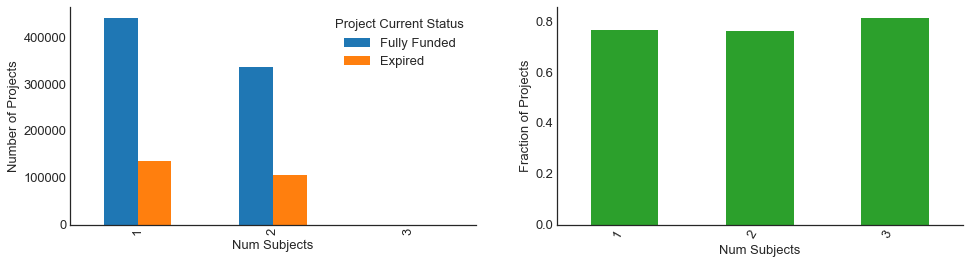

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4), sharex = True)
subject_grp_num[['Fully Funded', 'Expired']].plot(kind = 'bar', ax = ax1)
subject_grp_num['Frac Funded'].plot(kind = 'bar', ax = ax2, color = 'C2')
despine([ax1, ax2])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 60, ha = 'right');
ax1.set_ylabel('Number of Projects')
ax2.set_ylabel('Fraction of Projects')

### Are certain categories more likely to be fully funded? 

In [15]:
subject_grp = finished_projects_df.groupby(['Project Subject Category Tree'])
subject_grp_fund = subject_grp['Project Current Status'].value_counts().unstack()
subject_grp_fund['Frac Funded'] = subject_grp_fund['Fully Funded']/(subject_grp_fund['Expired']+subject_grp_fund['Fully Funded'])

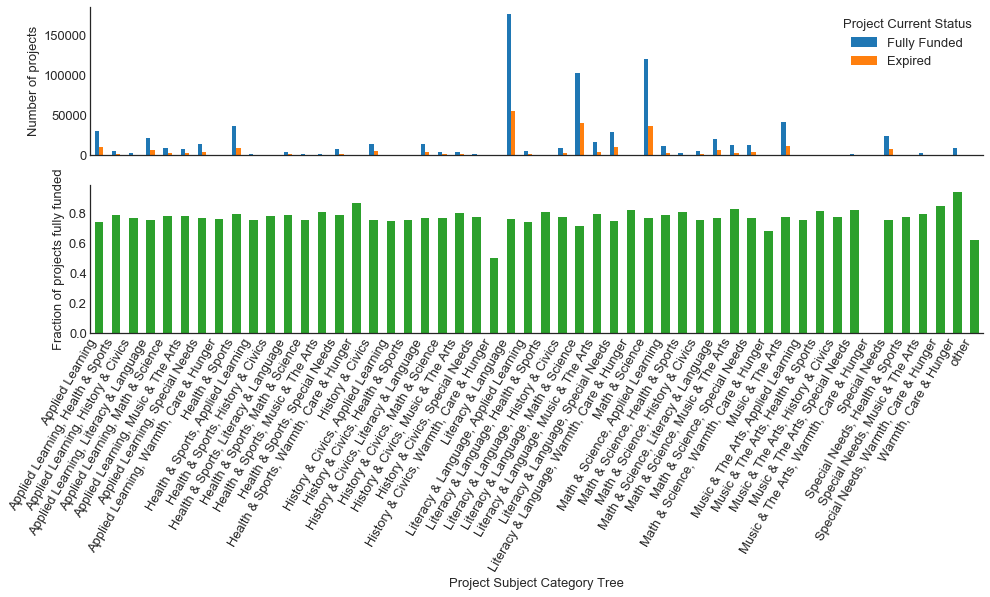

In [16]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (16,6), sharex = True)
subject_grp_fund[['Fully Funded', 'Expired']].plot(kind = 'bar', ax = ax1)
subject_grp_fund['Frac Funded'].plot(kind = 'bar', ax = ax2, color = 'C2')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 60, ha = 'right');
ax1.set_ylabel('Number of projects')
ax2.set_ylabel('Fraction of projects fully funded')
despine([ax1,ax2])

In [19]:
## split categories into multiple columns
finished_projects_df['Project Subject Category Tree'].fillna('other')
mult_cat = finished_projects_df['Project Subject Category Tree'].str.split(', ', expand = True)
mult_cat = pd.concat([mult_cat,finished_projects_df[['Project Current Status', 'Project Cost']]], axis = 1)

## duplicate project rows with multiple categories but label each duplicate with a different category under which it was listed
mult_cat_first = mult_cat[[0,'Project Current Status']]
mult_cat_second = mult_cat[[1,'Project Current Status']].rename(columns = {1:0})
mult_cat_third = mult_cat[[2, 'Project Current Status']].rename(columns = {2:0})
mult_cat_all = pd.concat([mult_cat_first,mult_cat_second,mult_cat_third], axis = 0)

## count number of projects fully funded
subject_grp_one_cat_grouped = mult_cat_all.groupby(0)['Project Current Status']
subject_grp_one_cat = subject_grp_one_cat_grouped.value_counts().unstack()
subject_grp_one_cat['Num Projects'] = subject_grp_one_cat['Expired']+subject_grp_one_cat['Fully Funded']
subject_grp_one_cat['Frac Funded'] = subject_grp_one_cat['Fully Funded']/subject_grp_one_cat['Num Projects']

## correct 'Warmth' category because it actually part of  'Warmth Care and Hunger'
subject_grp_one_cat = subject_grp_one_cat.stack().drop('Warmth').unstack()
subject_grp_one_cat = subject_grp_one_cat.rename(index = {'Care & Hunger': 'Warmth, Care & Hunger'})
subject_grp_one_cat = subject_grp_one_cat.sort_values('Num Projects')
subject_grp_one_cat

Project Current Status,Expired,Fully Funded,Num Projects,Frac Funded
0,,,,
other,11.0,18.0,29.0,0.620690
"Warmth, Care & Hunger",539.0,8620.0,9159.0,0.941151
History & Civics,16315.0,53462.0,69777.0,0.766184
Health & Sports,15307.0,59081.0,74388.0,0.794228
Music & The Arts,22749.0,85696.0,108445.0,0.790225
Special Needs,29269.0,93264.0,122533.0,0.761134
Applied Learning,33435.0,107407.0,140842.0,0.762606
Math & Science,98520.0,302143.0,400663.0,0.754108
Literacy & Language,130983.0,396092.0,527075.0,0.751491


Text(0.5,0,'')

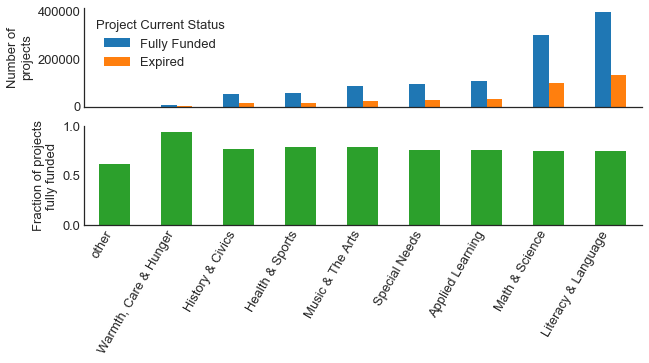

In [20]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,4), sharex = True)
subject_grp_one_cat[['Fully Funded', 'Expired']].plot(kind = 'bar', ax = ax1)
subject_grp_one_cat['Frac Funded'].plot(kind = 'bar', ax = ax2, color = 'C2')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 60, ha = 'right');
ax1.set_ylabel('Number of\nprojects')
ax2.set_ylabel('Fraction of projects\nfully funded')
despine([ax1,ax2])
ax2.set_ylim(0,1)
ax2.set_xlabel('')

### Restructure data such that each row represents one donation for a given project

In [21]:
cols_in_finish_df =  ['Project ID', 'Project Posted Date', 'Project Cost','Project Current Status',
                      'Project End', 'Project Expiration Date', 'Days Open', 'Alloted Time']

proj_don_df = donations_df[['Project ID', 'Donation Received Date', 'Donation Amount']
                             ].merge(finished_projects_df[cols_in_finish_df], how = 'inner', on = ['Project ID'])

proj_don_df['Donation Received Date'] = pd.to_datetime(pd.to_datetime(proj_don_df['Donation Received Date']).dt.date)
proj_don_full = proj_don_df.sort_values(['Project ID', 'Donation Received Date']).reset_index(drop = True)
proj_don_full.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410411 entries, 0 to 4410410
Data columns (total 10 columns):
Project ID                 4410411 non-null object
Donation Received Date     4410411 non-null datetime64[ns]
Donation Amount            4410411 non-null float64
Project Posted Date        4410411 non-null datetime64[ns]
Project Cost               4410411 non-null float64
Project Current Status     4410411 non-null object
Project End                4410411 non-null datetime64[ns]
Project Expiration Date    4410411 non-null datetime64[ns]
Days Open                  4410411 non-null int32
Alloted Time               4410411 non-null float64
dtypes: datetime64[ns](4), float64(3), int32(1), object(2)
memory usage: 319.7+ MB


### Add back descriptive project features for each donation

In [22]:
proj_don_full['Cum Donations'] = proj_don_full['Donation Amount'].fillna(0)
proj_groups = proj_don_full.groupby('Project ID')
proj_don_full['Cum Donations'] = proj_groups['Cum Donations'].cumsum()

#### Calculate features that donors may be using to decide whether to donate: 
* Days since posting/days until expiry
* Percent of asking price that has been donated

In [23]:
proj_don_full['Percent Completed'] = proj_don_full['Cum Donations']/proj_don_full['Project Cost']
proj_don_full['Percent Completed'] = proj_don_full['Percent Completed'].clip(upper = 1)

proj_don_full['Days Since Posting'] = proj_don_full['Donation Received Date'] - proj_don_full['Project Posted Date']
proj_don_full['Days Since Posting'] = pd.to_numeric(proj_don_full['Days Since Posting']/np.timedelta64(1, 'D'))
proj_don_full['Days Until Expiration'] = pd.to_datetime(proj_don_full['Project Expiration Date']) - proj_don_full['Donation Received Date']
proj_don_full['Days Until Expiration'] = pd.to_numeric(proj_don_full['Days Until Expiration']/np.timedelta64(1, 'D'))

### Although DonorsChoose projects are supposed to have a limit of 4 months, a small fraction of projects are allowed to stay active for longer
* This means that we should normalize 'days since posting' and 'days until expiration' to the total alotted time for each project in order to compare between
projects

In [24]:
proj_don_full['Frac of alloted time elapsed'] = proj_don_full['Days Since Posting']/proj_don_full['Alloted Time']
proj_don_full['Frac of alloted time elapsed'] = proj_don_full['Frac of alloted time elapsed'].clip(upper = 1)

#group donations by project ID and then calculate the mean and cummulative donation amount for each project
proj_don_full = proj_don_full.sort_values('Days Open').reset_index(drop = True)
proj_grps = proj_don_full.groupby('Project ID', sort = False)
mean_don_amount = proj_grps['Donation Amount'].mean().to_frame().reset_index()
max_cummulative_donations = pd.DataFrame(proj_grps['Cum Donations'].max().reset_index())

#merge calculted mean donation amount and cumulative donation amount back into finished_project_df
finished_projects_df = finished_projects_df.merge(mean_don_amount, how = 'left')
finished_projects_df = finished_projects_df.merge(max_cummulative_donations, on = 'Project ID', how = 'left')
finished_projects_df['Cum Donations'] = finished_projects_df['Cum Donations'].fillna(0)


### Plotting the cumulative donations over asking price for projects that are marked as 'Fully Funded' shows that some donations are missing from the dataset.
* This is due to DonorsChoose removing donations that were given by certain organizations that matched donations by employees from the dataset
* This means that all of the projects where the cummulative recorded donations equals the asking price are those that did not recieve any matched donations

In [25]:
ffunded = finished_projects_df['Project Current Status'] == 'Fully Funded'

count    778137.000000
mean          0.561247
std           0.353331
min           0.000000
25%           0.285934
50%           0.533669
75%           0.906732
max           2.550013
Name: Cum Don/Cost, dtype: float64

'Fully funded projects that likely have a organization matching donations: 676125'

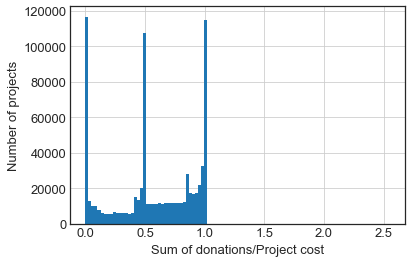

In [26]:
finished_projects_df['Cum Don/Cost'] = finished_projects_df['Cum Donations']/finished_projects_df['Project Cost']
display(finished_projects_df.loc[ffunded,'Cum Don/Cost'].hist(bins = 100))
plt.ylabel('Number of projects')
plt.xlabel('Sum of donations/Project cost')
display(finished_projects_df.loc[ffunded,'Cum Don/Cost'].describe())
'Fully funded projects that likely have a organization matching donations: '+ str(sum(finished_projects_df.loc[ffunded,'Cum Don/Cost']<1))

In [27]:
match = finished_projects_df['Cum Don/Cost'] < 1
finished_projects_df.loc[match&ffunded, 'Project Current Status'] = 'Fully Funded(match)'
proj_don_full = proj_don_full.merge(finished_projects_df[['Project ID', 'Project Current Status']], on = 'Project ID', how = 'left')
proj_don_full = proj_don_full.reset_index(drop = True)

In [ ]:
edges = np.arange(0,1, 0.01)
hists = proj_don_full.groupby('Project ID', sort = False)['Frac of alloted time elapsed'].apply(lambda x:
                                                                                                np.histogram(x, bins = edges)).to_frame()
hists = hists['Frac of alloted time elapsed'].apply(lambda x: x[0])
hists = hists.reset_index().rename(columns = {'Frac of alloted time elapsed':'Donation hist'})
finished_projects_df = finished_projects_df.merge(hists, on = 'Project ID', how = 'left')

isnull = finished_projects_df['Donation hist'].isnull()
finished_projects_df.loc[isnull,'Donation hist'] = finished_projects_df.loc[isnull,'Donation hist'].apply(lambda x:
                                                                                                          np.zeros([1,99])[0])

finished_projects_df['Donation Amount'] = finished_projects_df['Donation Amount'].fillna(0)

In [ ]:
finished_projects_df = finished_projects_df.sort_values('Days Open')
grped_by_outcome = finished_projects_df.groupby('Project Current Status', sort = False)
grped_hists = grped_by_outcome['Donation hist'].apply(lambda x: np.vstack(x.values)).values
grped_costs = grped_by_outcome['Project Cost'].apply(lambda x: np.vstack(x.values)).values
grped_mean_don = grped_by_outcome['Donation Amount'].apply(lambda x: np.vstack(x.values)).values

In [ ]:
def plot_rast_hist(hists,costs,mean_don, xlabel):
    ratio = np.array([hists[0].shape[0],hists[1].shape[0]])/hists[2].shape[0]
    fig, axes =  plt.subplots(4,3, figsize = (12,12), gridspec_kw = {'height_ratios':[ratio[0],ratio[1], 1, 1], 'width_ratios':[6,1,3]})
    axes[0,0].get_shared_x_axes().join(axes[0,0],axes[1,0],axes[2,0],axes[3,0])
    axes[0,1].get_shared_x_axes().join(axes[0,1],axes[1,1],axes[2,1],axes[3,1])
    axes[0,2].get_shared_x_axes().join(axes[0,2],axes[1,2],axes[2,2],axes[3,2])
    conv_wind = int(hists[0].shape[0]*0.01)
    
    fig.subplots_adjust(wspace = 0.1)
    axes[3,1].axis('off')
    axes[3,2].axis('off')
    hist_colors = ['C3', 'C4', 'k']
    for n, ax,ax1,ax2,group,cost,don, c in zip([0,1,2],axes[:,0],axes[:,1],axes[:,2], hists, costs, mean_don, hist_colors):
#         import pdb; pdb.set_trace()
        raster = ax.imshow(group, aspect = 'auto', vmax = 5, cmap = 'gist_heat_r')
        hist = np.sum(group, axis = 0)
        num_dons = np.convolve(np.sum(group, axis = 1), [1/conv_wind]*conv_wind, mode = 'same')
        don = np.convolve(don.ravel(), [1/conv_wind]*conv_wind, mode = 'same')
        cost = np.convolve(cost.ravel(), [1/conv_wind]*conv_wind, mode = 'same')
        
        ax1.plot(num_dons,np.arange(0,len(num_dons)))
        ax1.fill_betweenx(np.arange(0, len(num_dons),1), num_dons, color = 'C0', alpha = 0.5)
        ax2.plot(cost, np.arange(0, len(cost),1), color = 'C2', alpha = 0.2)
        ax2.fill_betweenx(np.arange(0, len(cost),1), cost, color = 'C2', alpha = 0.5)
        ax2.plot(don, np.arange(0, len(don),1), color = 'C2', alpha = 0.5)
        ax2.fill_betweenx(np.arange(0, len(don),1), don, color = 'C2', alpha = 0.5)
        axes[3,0].plot(hist/np.sum(hist), color = c)

        ax1.set_ylim(len(num_dons), 0)
        if np.max(num_dons) > ax1.get_xlim()[1]:
            ax1.set_xlim(0, np.max(num_dons))
        if np.max(cost) > ax2.get_xlim()[1]:
            ax2.set_xlim(0, np.max(cost))
        ax2.set_xlim(0, 2000)

        if n == 2:
            ax2.plot(num_dons*don, np.arange(0, len(num_dons),1), color ='k',alpha = 0.5)
            
        ax2.set_ylim(len(cost), 0)
        
        ax1.axes.get_yaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)
        [ax.spines[side].set_visible(False) for side in ['right', 'top']]
        [ax1.spines[side].set_visible(False) for side in ['right', 'top', 'left']]
        [ax2.spines[side].set_visible(False) for side in ['right', 'top', 'left']]

        
    [axes[3, 0].spines[side].set_visible(False) for side in ['right', 'top']]
    axes[3, 0].set_xlim(0, 100)
    axes[3, 0].set_xlabel(xlabel)
    
    axes[0, 0].set_ylabel('Project num \n(fully fund. \nw match)')
    axes[1, 0].set_ylabel('Project num \n(fully fund. \nw/o match)')
    axes[2, 0].set_ylabel('Project num \n(expired)')
    axes[3, 0].set_ylabel('Fraction of \ndonations')
    axes[3, 0].text(0.5,0.7, 'Fully funded with match', color = 'C3', transform=axes[3, 0].transAxes)
    axes[3, 0].text(0.5,0.56, 'Fully funded without match', color = 'C4', transform=axes[3, 0].transAxes)
    axes[3, 0].text(0.5,0.42, 'Expired', color = 'k', transform=axes[3, 0].transAxes)
    
    axes[0, 1].text(.9,0.85, 'Total number of citizen donations', color = 'C0', transform=axes[0, 1].transAxes, rotation = 270, va = 'top')
    axes[0, 2].text(.72,0.85, 'Average donation amount ($)', color = 'C2', transform=axes[0, 2].transAxes, rotation = 270, va = 'top')
    axes[0, 2].text(0.82,0.85, 'Project cost ($)', color = 'C2', alpha = 0.7, transform=axes[0, 2].transAxes, rotation = 270, va = 'top')
    axes[2, 2].text(0.9,1, 'Total \ndonated ($)', color = 'k', alpha = 0.7, transform=axes[2, 2].transAxes, rotation = 270, va = 'top')

    cbaxes = fig.add_axes([.35, .85, 0.1, 0.01])  # This is the position for the colorbar
    cb = plt.colorbar(raster, cax = cbaxes, label = 'Number of citizen donations', orientation = 'horizontal')
    
    return fig

In [ ]:
idx = [0,1,2]
fig = plot_rast_hist(grped_hists[idx], grped_costs[idx],grped_mean_don[idx], 'Fraction of allotted time elapsed');

In [ ]:
grped_by_outcome[['Cum Donations', 'Project Cost']].get_group('Expired').describe()

In [ ]:
fig.savefig('DonorsChoose_MatchDonations_EF.png',dpi = 1200,format = 'png')

### Prepare data for a model 
* See how well a logistic regression model can predict whether a project will be fully funded based on asking price, number of donations during the first 5 days, and the average donation size during the first 5 days.

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
X = finished_projects_df[['Project ID', 'Project Cost','Project Current Status']]
first_10days = proj_grps.progress_apply(lambda x: x[x['Donation Received Date'] <= (x['Project Posted Date'] + pd.DateOffset(days = 10))])

In [ ]:
first10_grp = first_10days.reset_index(drop = True).groupby('Project ID')
first10_features = first10_grp['Donation Amount'].sum().reset_index().rename(columns = {'Donation Amount':'Cumulative Donation Amount 10days'})
first10_features['Number of Donations 10days'] = first10_grp['Donation Amount'].count().reset_index()['Donation Amount']

X = X.merge(first10_features, on = 'Project ID', how ='left')
X = X.merge(subject_features, on = 'Project ID', how ='left')
X = X.merge(datetime_features, on = 'Project ID', how ='left')

# X = X.drop('Project ID', axis = 1)
fillcols = ['Number of Donations 10days', 'Cumulative Donation Amount 10days']
X[fillcols] = X[fillcols].fillna(0)
Y = X.pop('Project Current Status')

X = X.reset_index(drop = True)
Y = Y.reset_index(drop = True)


In [ ]:
Y = Y.str.replace('\(match\)', '')
Y[Y == 'Fully Funded'] = 1
Y[Y == 'Expired'] = 0
Y = Y.astype(int)

In [ ]:
Y.to_hdf('yLabels.h5', 'table')
X.to_hdf('xFeatures.h5', 'table')

In [ ]:
Y = pd.read_hdf('yLabels.h5','table')
X = pd.read_hdf('xFeatures.h5', 'table')

In [ ]:
X.head()

### Normalize data for better model performance

In [ ]:
num_cols = X.columns[1:4]
classes = X.columns[4:]
num_cols, classes

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (16,4))

means = X[num_cols].mean(axis = 0)
stds = X[num_cols].std(axis = 0)
outliers = []
for n, ax, col in zip([0,1,2], axes, num_cols):
    outliers.append(np.where((X[col]-means[n])/stds[n] > 4.5)[0])
    bins = np.linspace(0, means[n]+3.5*stds[n])
    X[col].hist(bins = bins, normed = True, cumulative = False, ax = ax)
    ax.set_xlabel(col)
axes[0].set_ylabel('Fraction of projects');

display([len(out)/X.shape[0] for out in outliers])
num_outliers = len(np.unique(np.concatenate(outliers)))/X.shape[0]
print('fraction of projects that are outliers in at least one feature: ' +str(num_outliers))

In [ ]:
fig,axes = plt.subplots(1,3, figsize = (16,4))
X_log_scaled = np.log(X[num_cols]+1)
for n, ax, col in zip([0,1,2], axes, num_cols):
#     bins = np.linspace(0, means[n]+2*stds[n])
    X_log_scaled[col].hist(bins = 200, normed = True, cumulative = False, ax = ax)
    ax.set_xlabel(col)
axes[0].set_ylabel('Fraction of projects');

X_log_scaled = X_log_scaled.values;

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler.fit(X[num_cols].values)

In [ ]:
fig,axes = plt.subplots(1,3, figsize = (16,4))
# X_scaled = np.log(X+1).values #sscaler.transform(X)
X_scaled = scaler.transform(X[num_cols].values)
X_scaled = np.hstack([X_scaled, X[classes].values])
for col, ax in enumerate(axes):
    col_,edges = np.histogram(X_scaled[:,col], bins = np.arange(-2,15,.1), normed = True)
#     dx = edges[1] - edges[0]
#     cdf = np.concatenate([[0], np.cumsum(col_hist)*dx])
    ax.bar(edges[:-1], col_)
    ax.set_xlabel(X.columns[col])
    ax.set_xlim(-2,15)
axes[0].set_ylabel('Fraction of projects'); 


### Split into train and test sets

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=0)

In [ ]:
splits = next(sss.split(X_scaled, Y))
x_train, x_test = X_scaled[splits[0],:], X_scaled[splits[1],:]
x_train_log, x_test_log = X_log_scaled[splits[0],:], X_log_scaled[splits[1],:]

y_train, y_test = Y.iloc[splits[0]], Y.iloc[splits[1]]

In [ ]:
display(y_train.value_counts()/y_train.shape[0])
y_test.value_counts()/y_test.shape[0]

### Run data through a few classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import preprocessing

In [ ]:
def run_classifier(clf, x_train, y_train, name):
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_cv_pred = cross_val_predict(clf, x_train, y_train, cv = 3)
    if hasattr(clf, 'decision_function'):
        y_cv_pred_scores = cross_val_predict(clf, x_train, y_train, cv = 3, method = 'decision_function')
    else:
        y_cv_pred_scores = cross_val_predict(clf, x_train, y_train, cv = 3, method = 'predict_proba')[:,1]
    
    print('----------------------'+name+'------------------------------') 
    print('train rmse: '+ str(np.sqrt(mean_squared_error(y_train, y_train_pred))))
    print('cval rmse: '+ str(np.sqrt(mean_squared_error(y_train, y_cv_pred)))+'\n')
    print('confusion matrix:')
    display(pd.DataFrame(confusion_matrix(y_train, y_cv_pred), index = ['Neg', 'Pos'], columns=['Pred Neg', 'Pred Pos']))
    print('\n')
    print('auROC: ' +str(roc_auc_score(y_train, y_cv_pred_scores)))
    print('\n')

#### Run models using log scaled data

In [ ]:
x_train_log

In [ ]:
classifiers = {'SGD':SGDClassifier(alpha = 0.00001, max_iter = 400, tol = 0.001, random_state=42),
             'DecisionTree': DecisionTreeClassifier(),
             'RandomForest': RandomForestClassifier(n_estimators=100, random_state=0,  n_jobs = -1)}

for name,clf in classifiers.items(): run_classifier(clf, x_train_log, y_train, name) 

#### Run models on Z-scored data

In [ ]:
classifiers = {'SGD':SGDClassifier(alpha = 0.00001, max_iter = 400, tol = 0.001, random_state=42),
             'DecisionTree': DecisionTreeClassifier(),
             'RandomForest': RandomForestClassifier(n_estimators=100, random_state=0,  n_jobs = -1)}

for name,clf in classifiers.items(): run_classifier(clf, x_train, y_train, name) 

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (18,4))
feature_importances = pd.DataFrame({feat:imp for feat, imp in zip(list(X.columns[1:]), 
                                                                  classifiers['RandomForest'].feature_importances_)}, index = [0]).T
feature_importances.plot.bar(legend = False, ax = ax)
plt.xticks(rotation=65, ha = 'right')
# ax.set_xticklabels(['Project cost','Cummulative\ndonations\nfirst 5 days','Number of\ndonations\nfirst 5 days'])

#### look at date as a predictor but be careful of the surge completion days due to special events